# Sequence to sequence implementation

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount(mountpoint='/content/drive/')

Mounted at /content/drive/


## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



**Download the data**

In [3]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2022-11-10 09:25:08--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7882203 (7.5M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.52M  3.79MB/s    in 2.0s    

2022-11-10 09:25:10 (3.79 MB/s) - ‘ita-eng.zip’ saved [7882203/7882203]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [4]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-11-10 09:25:11--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-11-10 09:25:11--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc326a502332daadb897c8119f1e.dl.dropboxusercontent.com/cd/0/inline/BweQw5utN7v7mQleKV5EtTHk1bttQLeNCX-CBxPAMcB66erLygW7nADpHt4uALVULHWjgzx97Rtg1XejzX8PFEDf55KdJdYMIpWYhGUEKrGWJvd2lh4b8_6R1d6AiHxJAh0d7GoKARq1QueOwKCLR4ref0z6P4612Xht-GyEqQwDtw/file# [following]
--2022-11-10 09:25:11--  https://uc326a502332daadb897c8119f1e.dl.dropboxusercontent.com/cd/0/inline/BweQw5utN7v7mQleKV5EtTHk1bttQLeNCX-CBxPAMcB66erLygW7nADpHt4uAL

In [5]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use(style='seaborn-notebook')

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import tensorflow as tf

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model

**Load the data**

In [10]:
with open(file='ita.txt', mode='r', encoding="utf8") as f:
    eng = []
    ita = []
    for line in f.readlines():
        line_split = line.split("\t")
        eng.append(line_split[0])
        ita.append(line_split[1])

In [11]:
data = pd.DataFrame(data=list(zip(eng, ita)), columns=['english','italian'])
print(data.shape)
data.head()

(358373, 2)


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


**Preprocess data**

Reference: https://stackoverflow.com/a/47091490/7579443

In [12]:
def decontractions(phrase):
    """
    Decontracted takes text and convert contractions into natural form.
    """
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase

In [13]:
def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(phrase=text)
    text = re.sub(pattern='[^A-Za-z0-9 ]+', repl='', string=text)
    return text

In [14]:
def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    text = text.lower()
    text = decontractions(phrase=text)
    text = re.sub(pattern='[$)\?"’.°!;\'€%:,(/]', repl='', string=text)
    text = re.sub(pattern='\u200b', repl=' ', string=text)
    text = re.sub(pattern='\xa0', repl=' ', string=text)
    text = re.sub(pattern='-', repl=' ', string=text)
    return text

In [15]:
data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [16]:
ita_lengths = data['italian'].str.split().apply(len)
eng_lengths = data['english'].str.split().apply(len)

In [17]:
for i in range(0, 101, 10):
    print(i, np.percentile(a=ita_lengths, q=i))
print()
for i in range(90, 101):
    print(i, np.percentile(a=ita_lengths, q=i))
print()
for i in np.round(a=np.linspace(start=99.1, stop=100, num=10), decimals=1):
    print(i, np.percentile(a=ita_lengths, q=i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0

90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0

99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100.0 92.0


If you observe the values, 99.9% of the data points are having length < 20, so select the sentences that have words < 20.

In order to do the teacher forcing while training of seq-seq models, lets create two new columns, one with  < start > token at begining of the sentence and other column with < end > token at the end of the sequence.

In [18]:
data['italian_len'] = data['italian'].str.split().apply(len)
data = data[data['italian_len'] < 20]

data['english_len'] = data['english'].str.split().apply(len)
data = data[data['english_len'] < 20]

data['english_inp'] = '<start> ' + data['english'].astype(str)
data['english_out'] = data['english'].astype(str) + ' <end>'

data = data.drop(['english', 'italian_len', 'english_len'], axis=1)
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [19]:
data.sample(10)

,italian,english_inp,english_out
42138,tom è il nemico,<start> tom is the enemy,tom is the enemy <end>
266649,tom guarda troppa televisione,<start> tom watches too much television,tom watches too much television <end>
100031,qual è il suo indirizzo,<start> what is your address,what is your address <end>
118402,vieni a visitarci qualche volta,<start> come visit us sometime,come visit us sometime <end>
348196,ho già lavorato qui per diverse ore,<start> i have already been working here for s...,i have already been working here for several h...
1310,sentite questo,<start> feel this,feel this <end>
124237,sto andando a comprare del pane,<start> i am going to buy bread,i am going to buy bread <end>
262793,è una questione di vita e di morte,<start> it is a matter of life and death,it is a matter of life and death <end>
309999,tom ha chiesto a mary di spegnere la luce,<start> tom asked mary to turn off the light,tom asked mary to turn off the light <end>
158553,la nostra famiglia è molto felice,<start> our family is very happy,our family is very happy <end>


**Data splitting**

In [20]:
train, validation = train_test_split(data, test_size=0.2)

In [21]:
print(train.shape, validation.shape)

(286292, 3) (71574, 3)


In [22]:
# For one sentence we will be adding <end> token so that the tokanizer learns the word <end>.
# With this we can use only one tokenizer for both encoder output and decoder output.
train.iloc[0]['english_inp'] = str(train.iloc[0]['english_inp']) + ' <end>'
train.iloc[0]['english_out'] = str(train.iloc[0]['english_out']) + ' <end>'

In [23]:
train.head()

,italian,english_inp,english_out
22901,tom perse il conto,<start> tom lost count <end>,tom lost count <end> <end>
312872,lei ha mai mangiato le uova col ketchup,<start> have you ever eaten eggs with ketchup,have you ever eaten eggs with ketchup <end>
276247,a tom non piaceva vivere a boston,<start> tom did not like living in boston,tom did not like living in boston <end>
89744,ho acconsentito ad aiutare tom,<start> i agreed to help tom,i agreed to help tom <end>
348576,questo è il libro più difficile che io abbia m...,<start> this is the most difficult book i have...,this is the most difficult book i have ever re...


In [24]:
validation.head()

,italian,english_inp,english_out
283694,vorrei una camera che si affacci sul giardino,<start> i would like a room facing the garden,i would like a room facing the garden <end>
274662,sembra che abbia molti amici,<start> she appears to have many friends,she appears to have many friends <end>
352277,tom era nel club di kyudo quando era al liceo,<start> tom was in the kyudo club when he was ...,tom was in the kyudo club when he was in high ...
151787,dammi un caffè per piacere,<start> give me a coffee please,give me a coffee please <end>
22843,tom non è saggio,<start> tom is not wise,tom is not wise <end>


In [25]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)

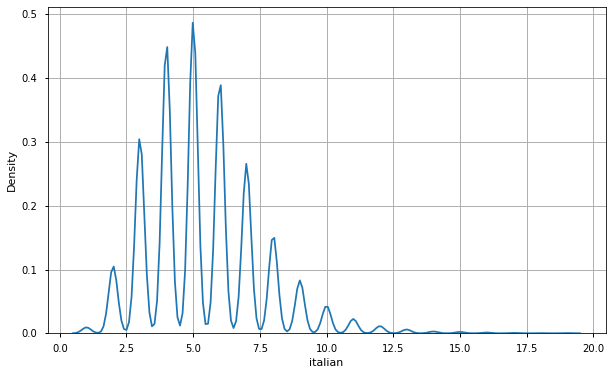

In [26]:
plt.figure(figsize=(10, 6))
sns.kdeplot(ita_lengths)
plt.grid()
plt.show()

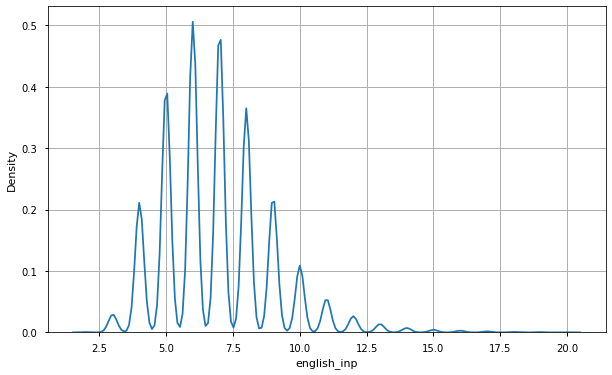

In [27]:
plt.figure(figsize=(10, 6))
sns.kdeplot(eng_lengths)
plt.grid()
plt.show()

**Tokenizer on the train data and learning vocabulary**

In [28]:
tokenize_ita = Tokenizer()
tokenize_ita.fit_on_texts(texts=train['italian'].values)

In [29]:
tokenize_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenize_eng.fit_on_texts(texts=train['english_inp'].values)

In [30]:
vocab_size_ita = len(tokenize_ita.word_index.keys())
print(vocab_size_ita)

26834


In [31]:
vocab_size_eng = len(tokenize_eng.word_index.keys())
print(vocab_size_eng)

13174


In [32]:
(tokenize_eng.word_index['<start>'], tokenize_eng.word_index['<end>'])

(1, 10399)

**Embeddings**

In [33]:
embeddings_index = dict()

In [34]:
with open(file='glove.6B.100d.txt', mode='r', encoding='UTF-8') as gf:
    for line in gf:
        split_values = line.split()
        word = split_values[0]
        emb_vec = np.asarray(a=split_values[1:], dtype='float32')
        embeddings_index[word] = emb_vec

In [35]:
embedding_matrix = np.zeros(shape=(vocab_size_eng+1, 100))

In [36]:
for word, i in tokenize_eng.word_index.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

In [37]:
embedding_matrix.shape

(13175, 100)

### Implement custom encoder decoder

**Encoder**

In [38]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- Takes a input sequence and returns encoder-outputs, encoder_final_state_h, encoder_final_state_c
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0

        # Initialize Embedding layer
        self.embedding = Embedding(input_dim=inp_vocab_size,
                                   output_dim=self.embedding_size,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name='Embedding_Layer_Encoder')
        
        # Intialize encoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_state=True, return_sequences=True, name='Encoder_LSTM')

    def call(self, input_sequence, states):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedded = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_embedded)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c

    def initialize_states(self, batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32, lstm_units], cell state zeros is of size [32, lstm_units]
      '''
      state_h = tf.zeros(shape=(batch_size, self.lstm_size))
      state_c = tf.zeros(shape=(batch_size, self.lstm_size))
      return state_h, state_c

**Grader function - 1**

In [39]:
def grader_check_encoder():
    '''
    vocab-size: Unique words of the input language,
    embedding_size: output embedding dimension for each word after embedding layer,
    lstm_size: Number of lstm units,
    input_length: Length of the input sentence,
    batch_size
    '''
    vocab_size = 10
    embedding_size = 20
    lstm_size = 32
    input_length = 10
    batch_size = 16

    # Intialzing encoder
    encoder = Encoder(inp_vocab_size=vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=input_length)
    input_sequence = tf.random.uniform(shape=[batch_size, input_length], maxval=vocab_size, minval=0, dtype=tf.int32)

    # Intializing encoder initial states
    initial_state = encoder.initialize_states(batch_size=batch_size)
    encoder_output, state_h, state_c = encoder(input_sequence=input_sequence, states=initial_state)
    
    assert(encoder_output.shape == (batch_size, input_length, lstm_size) and 
           state_h.shape == (batch_size, lstm_size) and 
           state_c.shape == (batch_size, lstm_size))
    return True

In [40]:
print(grader_check_encoder())

True


**Decoder**

In [41]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    
    def __init__(self, out_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length

        # Initialize Embedding layer
        self.embedding = Embedding(input_dim=self.out_vocab_size,
                                   output_dim=self.embedding_size,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name='Embedding_Layer_Decoder')
        
        # Intialize decoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_state=True, return_sequences=True, name='Decoder_LSTM')

    def call(self, input_sequence, initial_states):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        returns -- decoder_output, decoder_final_state_h, decoder_final_state_c
        '''
        target_embedded = self.embedding(input_sequence)
        lstm_output, lstm_state_h, lstm_state_c = self.lstm(target_embedded, initial_state=initial_states)
        return lstm_output, lstm_state_h, lstm_state_c

**Grader function - 2**

In [42]:
def grader_decoder():
    '''
    out_vocab_size: Unique words of the target language,
    embedding_size: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    input_length: Length of the input sentence,
    batch_size
    '''
    out_vocab_size = 13 
    embedding_dim = 12 
    input_length = 10
    dec_units = 16 
    batch_size = 32
    
    target_sentences = tf.random.uniform(shape=(batch_size, input_length), maxval=10, minval=0, dtype=tf.int32)
    encoder_output = tf.random.uniform(shape=[batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape=[batch_size, dec_units])
    state_c = tf.random.uniform(shape=[batch_size, dec_units])
    states = [state_h, state_c]

    # Intialzing encoder
    decoder = Decoder(out_vocab_size=out_vocab_size, embedding_size=embedding_dim, lstm_size=dec_units, input_length=input_length)
    output, _, _ = decoder(input_sequence=target_sentences, initial_states=states)

    assert(output.shape == (batch_size, input_length, dec_units))
    return True

In [43]:
print(grader_decoder())

True


In [44]:
class EncoderDecoderModel(tf.keras.Model):
    
    def __init__(self, inp_vocab_size, out_vocab_size, encoder_input_length, decoder_input_length):
        super().__init__()
        
        # Create encoder object
        self.encoder = Encoder(inp_vocab_size=inp_vocab_size,
                               embedding_size=50,
                               lstm_size=128,
                               input_length=encoder_input_length)
        
        # Create decoder object
        self.decoder = Decoder(out_vocab_size=out_vocab_size,
                               embedding_size=100,
                               lstm_size=128,
                               input_length=decoder_input_length)
        
        # Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(units=out_vocab_size, activation='softmax')
    
    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output, encoder_final_state_h, encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h, encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        Return decoder_outputs
        '''
        input_sequence, target_sequence = data[0], data[1]

        states = self.encoder.initialize_states(batch_size=1)
        (encoder_output,
         encoder_state_h,
         encoder_state_c) = self.encoder(input_sequence=input_sequence, states=states)
        
        decoder_output, _, _ = self.decoder(input_sequence=target_sequence,
                                            initial_states=[encoder_state_h, encoder_state_c])
        output = self.dense(decoder_output)
        return output

**Creating data pipeline**

In [45]:
class Dataset(object):

    def __init__(self, data, tokenize_ita, tokenize_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tokenize_ita = tokenize_ita
        self.tokenize_eng = tokenize_eng
        self.max_len = max_len
    
    def __getitem__(self, i):
        self.encoder_inp_seq = self.tokenize_ita.texts_to_sequences(texts=[self.encoder_inps[i]])
        self.decoder_inp_seq = self.tokenize_eng.texts_to_sequences(texts=[self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenize_eng.texts_to_sequences(texts=[self.decoder_outs[i]])
        self.encoder_inp_seq_padded = pad_sequences(sequences=self.encoder_inp_seq, maxlen=self.max_len, padding='post')
        self.decoder_inp_seq_padded = pad_sequences(sequences=self.decoder_inp_seq, maxlen=self.max_len, padding='post')
        self.decoder_out_seq_padded = pad_sequences(sequences=self.decoder_out_seq, maxlen=self.max_len, padding='post')
        return self.encoder_inp_seq_padded, self.decoder_inp_seq_padded, self.decoder_out_seq_padded
    
    def __len__(self):
        return len(self.encoder_inps)

In [46]:
class DataLoader(tf.keras.utils.Sequence):

    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))
    
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.squeeze(a=np.stack(arrays=samples, axis=1), axis=0) for samples in zip(*data)]
        # We are creating data like ([italian, english_inp], english_out) these are already converted into seq.
        return tuple([[batch[0], batch[1]], batch[2]])
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [47]:
train_dataset = Dataset(data=train, tokenize_ita=tokenize_ita, tokenize_eng=tokenize_eng, max_len=20)
validation_dataset = Dataset(data=validation, tokenize_ita=tokenize_ita, tokenize_eng=tokenize_eng, max_len=20)

In [48]:
batch_size = 1024

In [49]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size)

In [50]:
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print(validation_dataloader[0][0][0].shape, validation_dataloader[0][0][1].shape, validation_dataloader[0][1].shape)

(1024, 20) (1024, 20) (1024, 20)
(1024, 20) (1024, 20) (1024, 20)


In [51]:
# Create an object of EncoderDecoderModel class
# Compile the model and fit the model

model = EncoderDecoderModel(inp_vocab_size=vocab_size_ita+1,
                            out_vocab_size=vocab_size_eng+1,
                            encoder_input_length=20,
                            decoder_input_length=20)

In [52]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [53]:
epochs = 32
steps_per_epoch = train.shape[0] // batch_size
validation_steps = validation.shape[0] // batch_size

tracker = model.fit(x=train_dataloader,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=validation_dataloader,
                    validation_steps=validation_steps)

Epoch 1/32
279/279 [==============================] - 65s 202ms/step - loss: 1.9337 - accuracy: 0.1731 - val_loss: 1.6739 - val_accuracy: 0.2041
Epoch 2/32
279/279 [==============================] - 57s 203ms/step - loss: 1.5790 - accuracy: 0.2348 - val_loss: 1.4829 - val_accuracy: 0.2724
Epoch 3/32
279/279 [==============================] - 57s 203ms/step - loss: 1.4010 - accuracy: 0.3112 - val_loss: 1.3155 - val_accuracy: 0.3411
Epoch 4/32
279/279 [==============================] - 57s 204ms/step - loss: 1.2463 - accuracy: 0.3692 - val_loss: 1.1819 - val_accuracy: 0.3938
Epoch 5/32
279/279 [==============================] - 57s 203ms/step - loss: 1.1236 - accuracy: 0.4200 - val_loss: 1.0754 - val_accuracy: 0.4386
Epoch 6/32
279/279 [==============================] - 57s 203ms/step - loss: 1.0228 - accuracy: 0.4647 - val_loss: 0.9880 - val_accuracy: 0.4797
Epoch 7/32
279/279 [==============================] - 57s 203ms/step - loss: 0.9359 - accuracy: 0.5042 - val_loss: 0.9100 - val_ac

In [54]:
model.summary()

Model: "encoder_decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1433398   
                                                                 
 decoder_1 (Decoder)         multiple                  1434748   
                                                                 
 dense (Dense)               multiple                  1699575   
                                                                 
Total params: 4,567,721
Trainable params: 4,567,721
Non-trainable params: 0
_________________________________________________________________


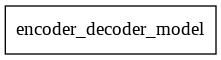

In [55]:
tf.keras.utils.plot_model(model=model,
                          to_file='model_1.png',
                          show_shapes=True,
                          show_layer_names=True,
                          expand_nested=False)

In [56]:
model.save_weights('/content/drive/MyDrive/Applied-AI/Assignment-31/seq2seq_encoder_decoder_model_1.h5')

In [57]:
tracker.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [58]:
def plot_model_performance(tracker, epochs):
    plt.figure(figsize=(18, 6))

    plt.subplot(121)
    plt.plot(range(1, epochs+1), tracker.history['accuracy'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_accuracy'], 'g--', label='validation')
    plt.title('Accuracy Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(122)
    plt.plot(range(1, epochs+1), tracker.history['loss'], 'r--', label='train')
    plt.plot(range(1, epochs+1), tracker.history['val_loss'], 'g--', label='validation')
    plt.title('Loss Plot')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.legend()
    plt.grid()

    plt.show()

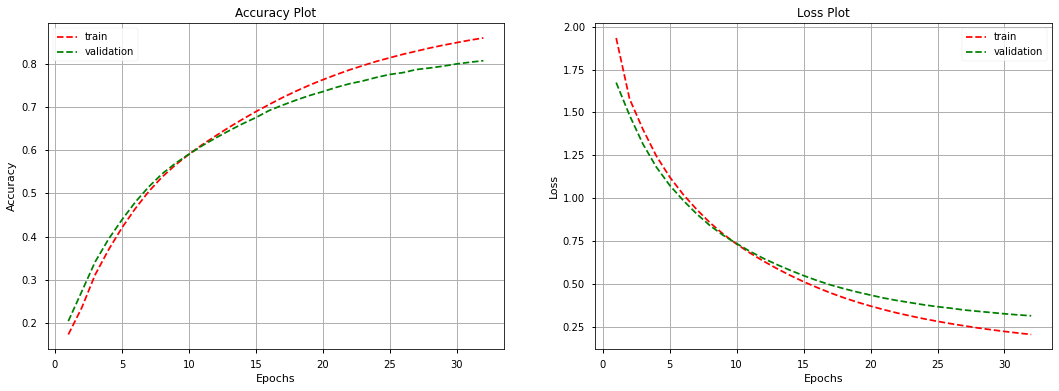

In [59]:
plot_model_performance(tracker=tracker, epochs=epochs)

In [60]:
ita_index_to_words = {v : k for k, v in tokenize_ita.word_index.items()}
eng_index_to_words = {v : k for k, v in tokenize_eng.word_index.items()}

In [61]:
def predict(input_sentence):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder, we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. Till we reach max_length of decoder or till the model predicted word <end>:
        predicted_out, state_h, state_c = model.layers[1](dec_input, states)
        pass the predicted_out to the dense layer
        update the states = [state_h, state_c]
        And get the index of the word with maximum probability of the dense layer output, 
            using the tokenizer(word index) get the word and then store it in a string.
        Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    input_sentence = '<start> ' + input_sentence + ' <end>'
    input_sequence = tokenize_ita.texts_to_sequences(texts=[input_sentence])
    input_sequence_padded = pad_sequences(sequences=input_sequence, maxlen=20, padding='post')

    input_vocab_size = vocab_size_ita + 1
    
    # initializing the encoder
    encoder = Encoder(inp_vocab_size=input_vocab_size, embedding_size=50, lstm_size=128, input_length=20)
    # initializing the dummy states
    initial_states = encoder.initialize_states(batch_size=32)
    # getting the outputs and states from the learned model's encoder layer
    encoder_output, encoder_state_h, encoder_state_c = model.layers[0](input_sequence=input_sequence_padded,
                                                                       states=initial_states)
    
    # decoder start index
    decoder_start_index = np.array([[tokenize_eng.word_index['<start>']]])
    # decoder's initial states which are encoder's final states
    decoder_initial_states = [encoder_state_h, encoder_state_c]
    
    predicted_words = []
    while True:
        # passing the <start> index to the learned model's decoder embedding layer
        target_embedded = model.layers[1].embedding(decoder_start_index)
        # getting the outputs and states
        decoder_output, decoder_state_h, decoder_state_c = model.layers[1].lstm(target_embedded, decoder_initial_states)
        
        # getting the inference output from the learned model's dense layer by passing the decoder output
        inference_output = model.layers[2](decoder_output)
        # updating the states
        decoder_initial_states = [decoder_state_h, decoder_state_c]

        # predicting the vector
        predicted_vec = np.reshape(a=np.argmax(inference_output), newshape=(1, 1))
        # updating the start index
        decoder_start_index = predicted_vec

        predicted_words.append(eng_index_to_words[predicted_vec[0][0]])

        if predicted_words[-1] == '<end>' or len(predicted_words) >= 20:
            break
    
    return " ".join(predicted_words[:-1])

In [62]:
input_sentence = 'ogni giorno ha il suo amore e dolore'
print("Original: {}".format(input_sentence))

output_sentence = predict(input_sentence)
print("Translated: {}".format(output_sentence))

Original: ogni giorno ha il suo amore e dolore
Translated: every day is your birthday and


In [63]:
import nltk.translate.bleu_score as bleu

In [64]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

def calculate_bleu(y_true, y_pred):
    y_true = y_true.strip().split()
    y_pred = y_pred.strip().split()
    return bleu.sentence_bleu(references=[y_true], hypothesis=y_pred)

In [65]:
def compute_score_on_data(data, n=100):
    data = data.sample(n=n)
    predictions = [predict(input_sentence=i) for i in data['italian'].values]
    # print(predictions)
    actuals = data['english_out'].apply(func=lambda x : x.replace('<end>', '')).values
    # print(actuals)
    score = np.mean(a=[calculate_bleu(y_true=y_true, y_pred=y_pred) for (y_true, y_pred) in zip(actuals, predictions)])
    return score

In [66]:
compute_score_on_data(data=validation)

0.3927572875999505

--- 

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### Implement custom encoder decoder and attention layers

**Encoder**

In [67]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- Takes a input sequence and returns encoder-outputs, encoder_final_state_h, encoder_final_state_c
    '''

    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        self.lstm_output = 0
        self.lstm_state_h = 0
        self.lstm_state_c = 0

        # Initialize Embedding layer
        self.embedding = Embedding(input_dim=inp_vocab_size,
                                   output_dim=self.embedding_size,
                                   input_length=self.input_length,
                                   mask_zero=True,
                                   name='Embedding_Layer_Encoder')
        
        # Intialize encoder LSTM layer
        self.lstm = LSTM(units=self.lstm_size, return_state=True, return_sequences=True, name='Encoder_LSTM')

    def call(self, input_sequence, states):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embedded = self.embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm(input_embedded)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c

    def initialize_states(self, batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32, lstm_units], cell state zeros is of size [32, lstm_units]
      '''
      state_h = tf.zeros(shape=(batch_size, self.lstm_size))
      state_c = tf.zeros(shape=(batch_size, self.lstm_size))
      return state_h, state_c

**Grader function - 1**

In [68]:
def grader_check_encoder():
    '''
    vocab-size: Unique words of the input language,
    embedding_size: output embedding dimension for each word after embedding layer,
    lstm_size: Number of lstm units,
    input_length: Length of the input sentence,
    batch_size
    '''
    vocab_size = 10
    embedding_size = 20
    lstm_size = 32
    input_length = 10
    batch_size = 16

    # Intialzing encoder
    encoder = Encoder(inp_vocab_size=vocab_size, embedding_size=embedding_size, lstm_size=lstm_size, input_length=input_length)
    input_sequence = tf.random.uniform(shape=[batch_size, input_length], maxval=vocab_size, minval=0, dtype=tf.int32)

    # Intializing encoder initial states
    initial_state = encoder.initialize_states(batch_size=batch_size)
    encoder_output, state_h, state_c = encoder(input_sequence=input_sequence, states=initial_state)
    
    assert(encoder_output.shape == (batch_size, input_length, lstm_size) and 
           state_h.shape == (batch_size, lstm_size) and 
           state_c.shape == (batch_size, lstm_size))
    return True

In [69]:
print(grader_check_encoder())

True


**Attention**

In [70]:
class Attention(tf.keras.layers.Layer):
    '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self, scoring_function, att_units):
        super().__init__()

        # Please go through the reference notebook and research paper to complete the scoring functions
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function == 'dot':
            # Intialize variables needed for Dot score function here
            pass
        
        if scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.W = Dense(units=att_units)

        elif scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            self.W_1 = Dense(units=self.att_units)
            self.W_2 = Dense(units=self.att_units)
            self.v = Dense(units=1)


    def call(self, decoder_hidden_state, encoder_output):
        '''
        Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
        * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
        '''
        
        # decder_hidden_state → h_s; encode_output → h_t
        # the shape of decoder_hidden_state is [batch_size, att_units]
        # the shape of encoder_output is [batch_size, input_length, att_units]

        if (self.scoring_function == 'dot'):
            # Implement Dot score function here
            score  = tf.keras.layers.Dot(axes=(1, 2))([decoder_hidden_state, encoder_output])
            
            attention_weights = tf.nn.softmax(score)
            attention_weights =  tf.expand_dims(attention_weights, -1)
            
            context_vector = tf.multiply(attention_weights, encoder_output)
            context_vector = tf.reduce_sum(context_vector, axis=1)
            
            return context_vector, attention_weights
        
        elif (self.scoring_function == 'general'):
            # Implement General score function here
            decoder_hidden_state = tf.keras.layers.Reshape((decoder_hidden_state.shape[1], 1))(decoder_hidden_state)
            score = tf.keras.layers.dot([self.W(encoder_output), decoder_hidden_state], axes=[2, 1])

            attention_weights  = tf.keras.activations.softmax(score)
            
            context_vector = tf.multiply(attention_weights, encoder_output)
            context_vector = tf.reduce_sum(context_vector, axis=1)

            return context_vector, attention_weights
        
        elif (self.scoring_function == 'concat'):
            # Implement General score function here

            # expand the dimensions of decoder_hidden_state on axis 1
            decoder_hidden_state_with_time = tf.expand_dims(decoder_hidden_state, 1)
            score = self.v(tf.nn.tanh(self.W_1(decoder_hidden_state_with_time) + self.W_2(encoder_output)))
        
            attention_weights = tf.keras.activations.softmax(score)
            context_vector = attention_weights * encoder_output
            context_vector = tf.reduce_sum(context_vector, axis=1)

            return context_vector, attention_weights
        
        return None, None

**Grader function - 2**

In [71]:
def grader_check_attention(scoring_fun):
    
    ''' 
    att_units: Used in matrix multiplications for scoring functions,
    input_length: Length of the input sentence,
    batch_size
    '''
    
    input_length = 10
    batch_size = 16
    att_units = 32
    
    state_h = tf.random.uniform(shape=[batch_size, att_units])
    encoder_output = tf.random.uniform(shape=[batch_size, input_length, att_units])
    attention = Attention(scoring_fun, att_units)
    context_vector, attention_weights = attention(state_h, encoder_output)
    assert(context_vector.shape == (batch_size, att_units) and attention_weights.shape == (batch_size, input_length, 1))
    return True

In [72]:
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


**OneStepDecoder**

In [73]:
class OneStepDecoder(tf.keras.Model):
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()

        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units

        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(
            input_dim=self.tar_vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.input_length,
            name="Embedding_Layer_OneStepDecoder"
        )

        # Intialize Decoder LSTM layer
        self.lstm = LSTM(
            units=self.dec_units,
            return_state=True,
            return_sequences=True,
            name="OneStepDecoder_LSTM"
        )

        # Intialize dense layer
        self.dense = Dense(self.tar_vocab_size, activation='softmax')

        # Attention
        self.attention = Attention(scoring_function=self.score_fun, att_units=self.att_units)
 
    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
        One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # A
        target_embedd = self.embedding(input_to_decoder)
        # B
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        # C
        target_context_concat = tf.concat([tf.expand_dims(context_vector, 1), target_embedd], axis=-1)
        # D
        initial_states = [state_h, state_c]
        decoder_output, decoder_hidden_state, decoder_cell_state = self.lstm(target_context_concat, initial_state=initial_states)
        # E
        output = self.dense(decoder_output)
        output = tf.squeeze(output, 1)

        # F
        return output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector

**Grader function - 3**

In [74]:
def grader_onestepdecoder(score_fun):
    '''
    tar_vocab_size: Unique words of the target language,
    embedding_dim: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    att_units: Used in matrix multiplications for scoring functions in attention class,
    input_length: Length of the target sentence, 
    batch_size
    '''
    tar_vocab_size = 13 
    embedding_dim = 12 
    input_length = 10
    dec_units = 16 
    att_units = 16
    batch_size = 32
    
    onestepdecoder = OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units)
    
    input_to_decoder = tf.random.uniform(shape=(batch_size, 1), maxval=10, minval=0, dtype=tf.int32)
    encoder_output = tf.random.uniform(shape=[batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape=[batch_size, dec_units])
    state_c = tf.random.uniform(shape=[batch_size, dec_units])
    (output,
     state_h,
     state_c,
     attention_weights,
     context_vector) = onestepdecoder(input_to_decoder, encoder_output, state_h, state_c)
    
    assert(output.shape == (batch_size, tar_vocab_size))
    assert(state_h.shape == (batch_size, dec_units))
    assert(state_c.shape == (batch_size, dec_units))
    assert(attention_weights.shape == (batch_size, input_length, 1))
    assert(context_vector.shape == (batch_size, dec_units))
    
    return True    

In [75]:
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


**Decoder**

In [76]:
class Decoder(tf.keras.Model):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()

        # Intialize necessary variables
        # Create an object from the class onestepdecoder
        self.onestepdecoder = OneStepDecoder(out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units)
    
    def call(self, input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state):

        # Initialize an empty Tensor array, that will store the outputs at each and every time step
        # Create a tensor array as shown in the reference notebook
        all_outputs = tf.TensorArray(dtype=tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")
        
        # Iterate till the length of the decoder input
        for timestep in range(tf.shape(input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.onestepdecoder(
                input_to_decoder[:, timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state
            )
            
            # Store the output in tensorarray
            all_outputs = all_outputs.write(timestep, output)
        
        all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
        # Return the tensor array
        return all_outputs

**Grader function - 4**

In [77]:
def grader_decoder(score_fun):
    '''
    out_vocab_size: Unique words of the target language,
    embedding_dim: output embedding dimension for each word after embedding layer,
    dec_units: Number of lstm units in decoder,
    att_units: Used in matrix multiplications for scoring functions in attention class,
    input_length: Length of the target sentence,
    batch_size
    '''
    out_vocab_size = 13
    embedding_dim = 12
    input_length = 11
    dec_units = 16
    att_units = 16
    batch_size = 32
    
    target_sentences = tf.random.uniform(shape=(batch_size, input_length), maxval=10, minval=0, dtype=tf.int32)
    encoder_output = tf.random.uniform(shape=[batch_size, input_length, dec_units])
    state_h = tf.random.uniform(shape=[batch_size, dec_units])
    state_c = tf.random.uniform(shape=[batch_size, dec_units])
    
    decoder = Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output = decoder(target_sentences, encoder_output, state_h, state_c)
    
    assert(output.shape == (batch_size, input_length, out_vocab_size))
    return True

In [78]:
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


**Encoder Decoder model**

In [79]:
class EncoderDecoderModel_Attention(tf.keras.Model):
    def __init__(self, input_vocab_size, output_vocab_size, encoder_inputs_length, decoder_inputs_length, score_fun, att_units):
        # Intialize objects from encoder decoder
        super().__init__()
        
        # Create encoder object
        self.encoder = Encoder(inp_vocab_size=input_vocab_size, 
                               embedding_size=300, 
                               input_length=encoder_inputs_length, 
                               lstm_size=100)
        
        # Create decoder object
        self.decoder = Decoder(out_vocab_size=output_vocab_size, 
                               embedding_dim=300, 
                               input_length=decoder_inputs_length, 
                               dec_units=100, 
                               score_fun=score_fun, 
                               att_units=att_units)
        
        # Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(output_vocab_size, activation='softmax')
    
    def call(self, data):
        input_sequence, target_sequence = data[0], data[1]

        # Intialize encoder states, Pass the encoder_sequence to the embedding layer
        self.states = self.encoder.initialize_states(1024)
        encoder_output, encoder_h, encoder_c = self.encoder(input_sequence, self.states)
        
        # Decoder initial states are encoder final states, Initialize it accordingly
        decoder_hidden_state, decoder_cell_state = encoder_h, encoder_c
        
        # Pass the decoder sequence, encoder_output, decoder states to Decoder
        decoder_output = self.decoder(target_sequence, encoder_output, decoder_hidden_state, decoder_cell_state)
        
        # return the decoder output
        return decoder_output

**Custom loss function**

In [80]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(real, pred):
    """ 
    Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

**Training**

In [81]:
def train_attention_models(score_fun, epochs):
    model = EncoderDecoderModel_Attention(input_vocab_size=vocab_size_ita + 1, 
                                          output_vocab_size=vocab_size_eng + 1, 
                                          encoder_inputs_length=20, 
                                          decoder_inputs_length=20, 
                                          score_fun=score_fun, 
                                          att_units=100)

    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    steps_per_epoch = train.shape[0] // 1024
    validation_steps = validation.shape[0] // 1024

    tracker = model.fit(x=train_dataloader,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, 
                        validation_data=validation_dataloader,
                        validation_steps=validation_steps)
    model.summary()

    #########
    model.save_weights('/content/drive/MyDrive/Applied-AI/Assignment-31/seq2seq_encoder_decoder_model_2{}.h5'.format(score_fun))

    return tracker, model

**Predict the sentence translation**

In [82]:
def prediction_by_attention(input_sentence, model):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of  as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word :
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    # input_sentence = '<start>' + input_sentence + '<end>'
    input_seq = tokenize_ita.texts_to_sequences([input_sentence])
    input_seq = pad_sequences(input_seq, maxlen=20, dtype='int32', padding='post')

    input_vocab_size = vocab_size_ita + 1
    output_vocab_size = vocab_size_eng + 1

    # Intializing encoder initial states
    encoder = Encoder(inp_vocab_size=input_vocab_size, embedding_size=100, input_length=20, lstm_size=256)
    initial_state = encoder.initialize_states(batch_size=1)
    encoder_output, enc_state_h, enc_state_c = model.layers[0](input_seq, initial_state)

    dec_state_h = enc_state_h
    dec_state_c = enc_state_c

    # start index
    dec_start_index = np.reshape(tokenize_eng.word_index['<start>'], (1, 1))

    pred_words = []
    attention_obtained = np.zeros([20, 20])
    

    i = 0
    while True:        
        (output,
         dec_state_h,
         dec_state_c,
         attention_weights,
         context_vector) = model.layers[1].onestepdecoder(dec_start_index, encoder_output, dec_state_h, dec_state_c)
        
        dec_state_h = dec_state_h
        dec_state_c = dec_state_c
        
        attention_weights = tf.squeeze(attention_weights)
        attention_obtained[i] = attention_weights
        
        cur_vec = np.reshape(np.argmax(output), (1, 1))
        dec_start_index = cur_vec

        # print(eng_index_to_words.get(cur_vec[0][0]))
        # print(cur_vec)
        pred_words.append(eng_index_to_words.get(cur_vec[0][0], ''))
        
        # finish when `end` token is found or the max length is reached
        if pred_words[-1] == '<end>' or len(pred_words) >= 20:
            break
        
        i += 1
    
    return ' '.join(pred_words[:-1]), attention_obtained

## Inference

**Plot attention weights**

In [83]:
def plot_attention(input_sentence, output_sentence, attention):
    #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
    from matplotlib import ticker
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attention)
    fig.colorbar(cax)
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + input_sentence.split(' '), fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output_sentence.split(' '), fontdict=fontdict)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    return None

**Calculate BLEU score**

In [84]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

def calculate_bleu(y_true, y_pred):
    y_true = y_true.strip().split()
    y_pred = y_pred.strip().split()
    return bleu.sentence_bleu(references=[y_true], hypothesis=y_pred)

In [85]:
def compute_score_on_data(data, model, n=100):
    data = data.sample(n=n)
    predictions = [prediction_by_attention(input_sentence=i, model=model)[0] for i in data['italian'].values]
    # print(predictions)
    actuals = data['english_out'].apply(func=lambda x : x.replace('<end>', '')).values
    # print(actuals)
    score = np.mean(a=[calculate_bleu(y_true=y_true, y_pred=y_pred) for (y_true, y_pred) in zip(actuals, predictions)])
    return score

Implement dot function here.

In [86]:
epochs = 32
tracker_dot, model_dot = train_attention_models(score_fun='dot', epochs=epochs)

Epoch 1/32
279/279 [==============================] - 146s 500ms/step - loss: 2.7406 - accuracy: 0.6672 - val_loss: 1.7707 - val_accuracy: 0.7169
Epoch 2/32
279/279 [==============================] - 138s 494ms/step - loss: 1.6460 - accuracy: 0.7345 - val_loss: 1.5243 - val_accuracy: 0.7500
Epoch 3/32
279/279 [==============================] - 138s 493ms/step - loss: 1.4213 - accuracy: 0.7650 - val_loss: 1.3130 - val_accuracy: 0.7800
Epoch 4/32
279/279 [==============================] - 138s 493ms/step - loss: 1.2303 - accuracy: 0.7900 - val_loss: 1.1536 - val_accuracy: 0.8004
Epoch 5/32
279/279 [==============================] - 139s 497ms/step - loss: 1.0803 - accuracy: 0.8120 - val_loss: 1.0207 - val_accuracy: 0.8208
Epoch 6/32
279/279 [==============================] - 138s 495ms/step - loss: 0.9532 - accuracy: 0.8306 - val_loss: 0.9096 - val_accuracy: 0.8370
Epoch 7/32
279/279 [==============================] - 138s 495ms/step - loss: 0.8453 - accuracy: 0.8464 - val_loss: 0.8150 -

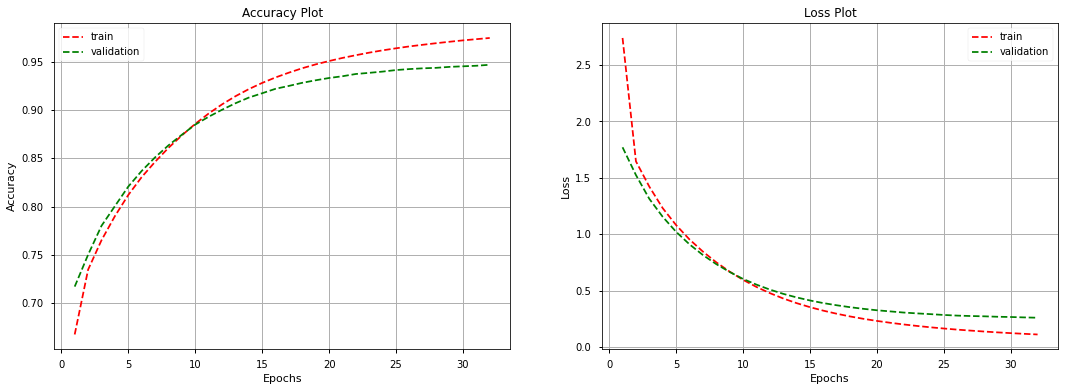

In [87]:
plot_model_performance(tracker=tracker_dot, epochs=epochs)

In [88]:
input_sentence = 'sembri veramente preoccupata'
print("Original: {}".format(input_sentence))

output_sentence, attention = prediction_by_attention(input_sentence, model_dot)
print("Translated: {}".format(output_sentence))

Original: sembri veramente preoccupata
Translated: you look really worried


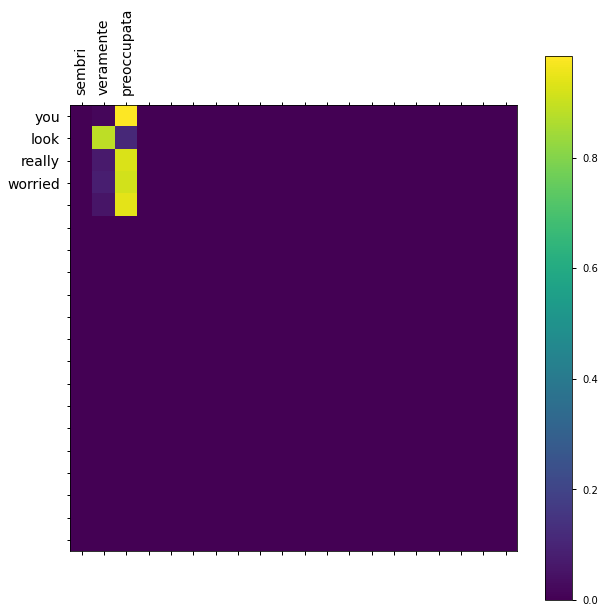

In [89]:
plot_attention(input_sentence=input_sentence, output_sentence=output_sentence, attention=attention)

In [90]:
compute_score_on_data(data=validation, model=model_dot)

0.4545791324481602

Implement general function here.

In [91]:
epochs = 32
tracker_general, model_general = train_attention_models(score_fun='general', epochs=epochs)

Epoch 1/32
279/279 [==============================] - 147s 503ms/step - loss: 2.7944 - accuracy: 0.6597 - val_loss: 1.9013 - val_accuracy: 0.6730
Epoch 2/32
279/279 [==============================] - 138s 496ms/step - loss: 1.8156 - accuracy: 0.6863 - val_loss: 1.7480 - val_accuracy: 0.7261
Epoch 3/32
279/279 [==============================] - 139s 497ms/step - loss: 1.6599 - accuracy: 0.7376 - val_loss: 1.6170 - val_accuracy: 0.7472
Epoch 4/32
279/279 [==============================] - 139s 497ms/step - loss: 1.4793 - accuracy: 0.7644 - val_loss: 1.4349 - val_accuracy: 0.7704
Epoch 5/32
279/279 [==============================] - 139s 498ms/step - loss: 1.2842 - accuracy: 0.7890 - val_loss: 1.2973 - val_accuracy: 0.7849
Epoch 6/32
279/279 [==============================] - 139s 498ms/step - loss: 1.1174 - accuracy: 0.8111 - val_loss: 1.1843 - val_accuracy: 0.7982
Epoch 7/32
279/279 [==============================] - 139s 499ms/step - loss: 0.9668 - accuracy: 0.8332 - val_loss: 1.0806 -

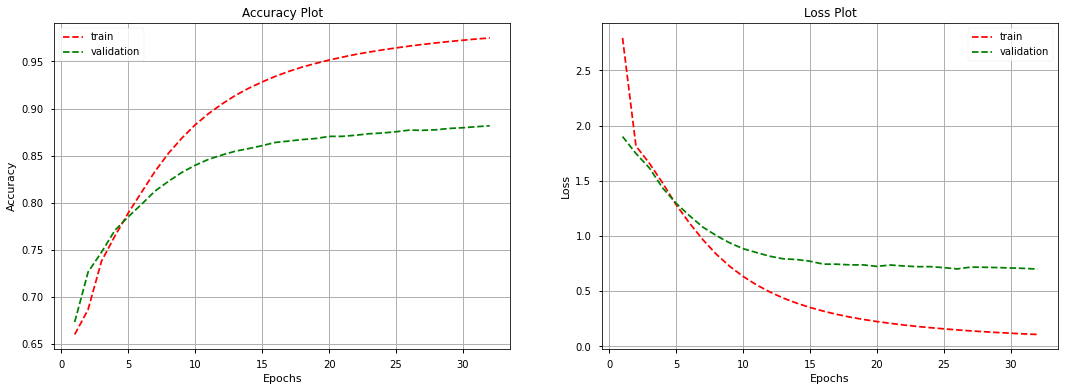

In [92]:
plot_model_performance(tracker=tracker_general, epochs=epochs)

In [93]:
input_sentence = 'sembri veramente preoccupata'
print("Original: {}".format(input_sentence))

output_sentence, attention = prediction_by_attention(input_sentence, model_general)
print("Translated: {}".format(output_sentence))

Original: sembri veramente preoccupata
Translated: you are you seem a worried about you


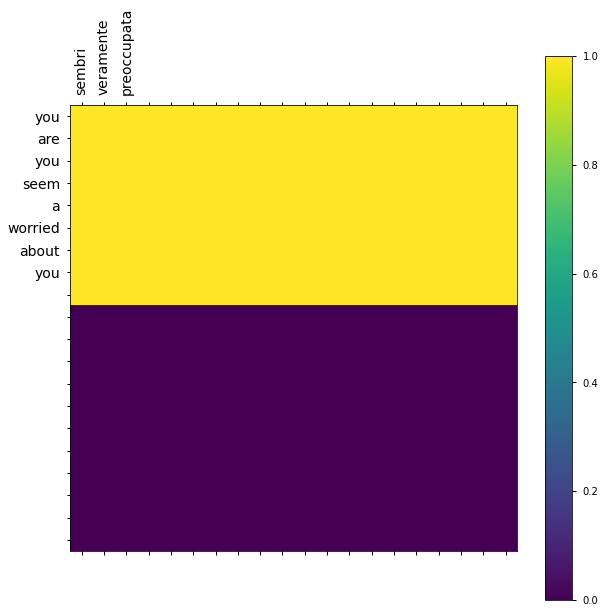

In [94]:
plot_attention(input_sentence=input_sentence, output_sentence=output_sentence, attention=attention)

In [95]:
compute_score_on_data(data=validation, model=model_general)

0.006888955203016989

Implement concat function here.

In [96]:
epochs = 32
tracker_concat, model_concat = train_attention_models(score_fun='concat', epochs=epochs)

Epoch 1/32
279/279 [==============================] - 159s 545ms/step - loss: 2.8146 - accuracy: 0.6595 - val_loss: 1.9533 - val_accuracy: 0.6731
Epoch 2/32
279/279 [==============================] - 151s 540ms/step - loss: 1.8441 - accuracy: 0.6822 - val_loss: 1.7721 - val_accuracy: 0.6951
Epoch 3/32
279/279 [==============================] - 151s 540ms/step - loss: 1.6412 - accuracy: 0.7306 - val_loss: 1.5673 - val_accuracy: 0.7492
Epoch 4/32
279/279 [==============================] - 151s 541ms/step - loss: 1.4153 - accuracy: 0.7701 - val_loss: 1.3783 - val_accuracy: 0.7724
Epoch 5/32
279/279 [==============================] - 152s 543ms/step - loss: 1.2163 - accuracy: 0.7964 - val_loss: 1.2254 - val_accuracy: 0.7964
Epoch 6/32
279/279 [==============================] - 151s 542ms/step - loss: 1.0389 - accuracy: 0.8227 - val_loss: 1.1060 - val_accuracy: 0.8114
Epoch 7/32
279/279 [==============================] - 151s 542ms/step - loss: 0.8882 - accuracy: 0.8443 - val_loss: 1.0060 -

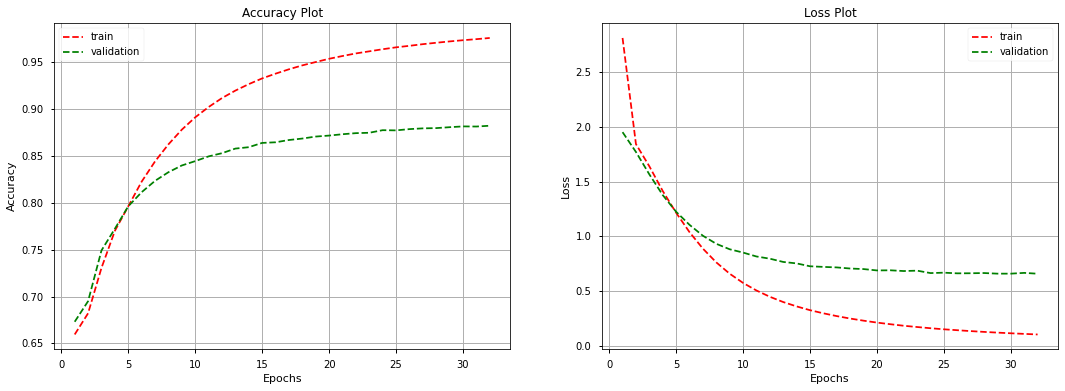

In [101]:
plot_model_performance(tracker=tracker_concat, epochs=epochs)

In [102]:
input_sentence = 'sembri veramente preoccupata'
print("Original: {}".format(input_sentence))

output_sentence, attention = prediction_by_attention(input_sentence, model_concat)
print("Translated: {}".format(output_sentence))

Original: sembri veramente preoccupata
Translated: you do not look at me about that


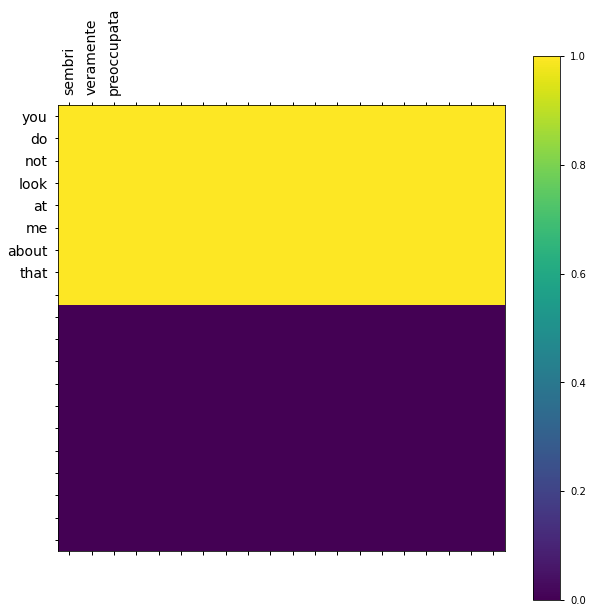

In [103]:
plot_attention(input_sentence=input_sentence, output_sentence=output_sentence, attention=attention)

In [104]:
compute_score_on_data(data=validation, model=model_concat)

0.017841753058495557

This is implementation of both seq2seq modelling and seq2seq with attention mechanism.

Task 1 is to implement seq2seq (Encoder Decoder) from scratch. This technique is limited to smaller sentences whenever we want to language translation.

Task 2 is to implement seq2seq (Attention Mechanism) from scratch. This technique is good and we can use this for larger sentences to perform language translation.
- Dot
- General
- Concat

These are the three attention techniques applied to get the similarity scores between encoder and decoder.

Dot attention score function (technique) has a hight bleu score.